In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error

In [2]:
titanic = sns.load_dataset("titanic")
print(titanic.shape)
titanic.head()

(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


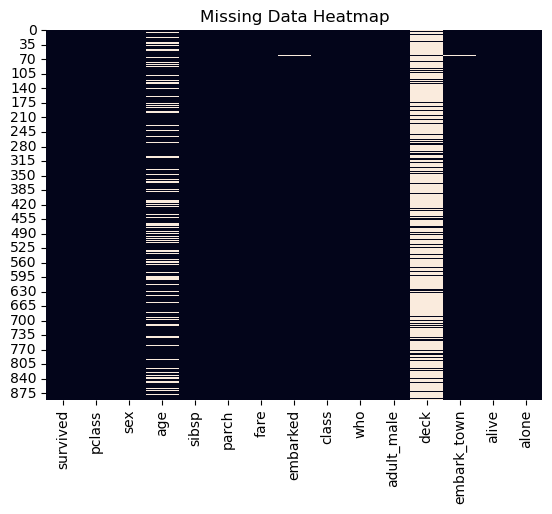

In [3]:
print(titanic.isna().sum())

# Visual heatmap
sns.heatmap(titanic.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

In [ ]:
drop_rows = titanic.dropna(subset=['age'])
drop_columns = titanic.drop(columns=['deck'])
drop_threst = titanic.dropna(thresh=14)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(titanic['age'],bins=30,kde=True,ax=ax[0])
ax[0].set_title("Original age dist")
sns.histplot(drop_rows['age'],bins=30,kde=True,ax=ax[1])
ax[1].set_title("After Deletion")
plt.show()

In [ ]:
df_del = titanic.dropna()
print("After Deletion Shape:", df_del.shape)

In [ ]:
imp_mean = SimpleImputer(strategy="mean")
titanic['age_mean'] = imp_mean.fit_transform(titanic[['age']])

imp_median = SimpleImputer(strategy="median")
titanic['age_median'] = imp_median.fit_transform(titanic[['age']])

imp_mode = SimpleImputer(strategy="most_frequent")
titanic['age_mode'] = imp_mode.fit_transform(titanic[['age']])

In [ ]:
titanic['age_ffill'] = titanic['age'].fillna(method='ffill')

In [ ]:
titanic['age_bfill'] = titanic['age'].fillna(method='bfill')

In [ ]:
knn = KNNImputer(n_neighbors=5)
titanic['age_knn'] = knn.fit_transform(titanic[['age','fare']])[:,0]

plt.figure(figsize=(10,5))
sns.kdeplot(titanic['age'], label='Original (with NaN)')
sns.kdeplot(titanic['age_mean'], label='Mean Imputed')
sns.kdeplot(titanic['age_median'], label='Median Imputed')
sns.kdeplot(titanic['age_knn'], label='KNN Imputed')
plt.legend(); plt.title("Age Imputation Comparison"); plt.show()

In [ ]:
# Apply linear interpolation on 'age'
titanic['age_linear'] = titanic['age'].interpolate(method='linear')
# Check before vs after for some rows with missing values
print(titanic.loc[titanic['age'].isna(), ['age','age_linear']].head(10))

In [ ]:
# Polynomial interpolation (order 2 = quadratic)
titanic['age_poly'] = titanic['age'].interpolate(method='polynomial', order=2)
# Spline interpolation (cubic smoothing)
titanic['age_spline'] = titanic['age'].interpolate(method='spline', order=3)

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(titanic['age'], label='Original (with NaN)')
sns.kdeplot(titanic['age_linear'], label='Linear')
sns.kdeplot(titanic['age_poly'], label='Polynomial (deg=2)')
sns.kdeplot(titanic['age_spline'], label='Spline (deg=3)')
plt.legend()
plt.title("Age Imputation: Interpolation Methods")
plt.show()

In [ ]:
from scipy.stats import zscore

titanic['fare_z'] = zscore(titanic['fare'].fillna(0))
outliers_z = titanic[np.abs(titanic['fare_z']) > 3]
print("Z-score outliers in fare:", outliers_z.shape[0])

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=titanic['fare'])
plt.title("Boxplot of Fare (Outliers appear as distant points)")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(titanic)), titanic['fare'], label="Data", alpha=0.6)
plt.scatter(outliers_z.index, outliers_z['fare'], color='red', label="Z-score Outliers", marker='x', s=60)
plt.xlabel("Passenger Index")
plt.ylabel("Fare")
plt.title("Fare with Z-score Outliers Highlighted")
plt.legend()
plt.show()

In [ ]:
# We'll use these numeric columns, dropping rows with all-NaN across them
num_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch']
X = titanic[num_cols].copy()

# --- Modified Z-score function ---
def modified_zscore(s: pd.Series):
    med = s.median()
    mad = (s - med).abs().median()
    return 0.6745 * (s - med) / mad

# Compute Modified Z-scores for 'fare'
mz = modified_zscore(X['fare'].dropna())
out_mz = mz.abs() > 3.5
print("Modified Z outliers (fare):", out_mz.sum())

In [ ]:
# --- Visualization 1: Boxplot ---
plt.figure(figsize=(8,4))
sns.boxplot(x=X['fare'], orient='h')
plt.title("Fare (boxplot) — robust check pairs well with MAD")
plt.show()

In [ ]:
# --- Visualization 2: Scatterplot with outliers highlighted ---
plt.figure(figsize=(10,5))
plt.scatter(range(len(X['fare'].dropna())), X['fare'].dropna(),
            label="Data", alpha=0.6)
plt.scatter(np.where(out_mz)[0], X['fare'].dropna()[out_mz],
            color='red', marker='x', s=60, label="Modified Z Outliers")
plt.xlabel("Passenger Index")
plt.ylabel("Fare")
plt.title("Fare with Modified Z-score Outliers Highlighted")
plt.legend()
plt.show()

In [ ]:
Q1 = titanic['fare'].quantile(0.25)
Q3 = titanic['fare'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

outliers_iqr = titanic[(titanic['fare'] < lower) | (titanic['fare'] > upper)]
print("IQR outliers in fare:", outliers_iqr.shape[0])

sns.boxplot(x=titanic['fare'])
plt.title("Boxplot: Fare with Outliers")
plt.show()

In [ ]:
# Prepare data
df_model = titanic[['fare','age','pclass']].dropna()

X = df_model[['age','pclass']]
y = df_model['fare']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("MSE (with outliers):", mean_squared_error(y_test, y_pred))

# Remove IQR outliers
df_no_out = df_model[(df_model['fare'] >= lower) & (df_model['fare'] <= upper)]
X_no, y_no = df_no_out[['age','pclass']], df_no_out['fare']
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_no, y_no, test_size=0.2, random_state=42)

lr2 = LinearRegression().fit(Xn_train, yn_train)
yn_pred = lr2.predict(Xn_test)
print("MSE (without outliers):", mean_squared_error(yn_test, yn_pred))